In [36]:
import sys, os

PROJECT_ROOT = os.path.abspath("..")
sys.path.insert(0, PROJECT_ROOT)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("Files in models:", os.listdir(os.path.join(PROJECT_ROOT, "models")))


PROJECT_ROOT: /Users/jerrysun/Desktop/contexto-ai-solver
Files in models: ['v1_word2vec', 'v2_bge']


In [37]:
from utils.vector_utils import load_embeddings
from utils.similarity import cosine_similarity
import os

vocab, embeddings, word_to_idx = load_embeddings(
    os.path.join(PROJECT_ROOT, "models/v1_word2vec/gensim_vocab.npy"),
    os.path.join(PROJECT_ROOT, "models/v1_word2vec/gensim_embeddings.npy")
)

def vector(word):
    return embeddings[word_to_idx[word]]


In [38]:
def nearest_neighbors(word, k=10):
    if word not in word_to_idx:
        print("OOV")
        return

    v = vector(word)
    sims = []

    for w in vocab:
        if w == word:
            continue
        sims.append((cosine_similarity(v, vector(w)), w))

    sims.sort(reverse=True)
    for s, w in sims[:k]:
        print(f"{w:15s} {s:.3f}")

In [39]:
def analogy(a, b, c, k=5):
    va, vb, vc = vector(a), vector(b), vector(c)
    target = vb - va + vc

    sims = []
    for w in vocab:
        if w in {a, b, c}:
            continue
        sims.append((cosine_similarity(target, vector(w)), w))

    sims.sort(reverse=True)
    for s, w in sims[:k]:
        print(f"{w:15s} {s:.3f}")

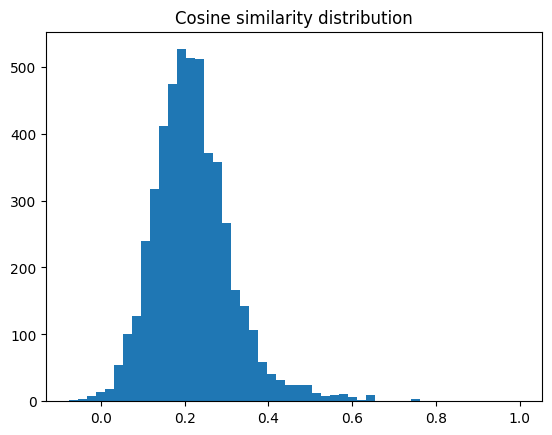

In [40]:
import matplotlib.pyplot as plt

word = "river"
v = vector(word)
sims = [cosine_similarity(v, vector(w)) for w in vocab[:5000]]

plt.hist(sims, bins=50)
plt.title("Cosine similarity distribution")
plt.show()

In [41]:
TARGET = "river"
target_vec = vector(TARGET)

def fake_score(word):
    return int(10000 * (1 - cosine_similarity(vector(word), target_vec)))


In [42]:
def run_fake_contexto(start_word, max_steps=30):
    history = []
    guessed = set()

    current = start_word
    guessed.add(current)

    for step in range(max_steps):
        score = fake_score(current)
        history.append((current, score))

        print(f"{step+1:02d}: {current:15s} score={score}")

        if score == 0:
            print("🎯 Solved!")
            break

        # --- solver logic (same idea as your real solver) ---
        best_word, best_score = min(history, key=lambda x: x[1])
        v_best = vector(best_word)

        candidates = []
        for w in vocab:
            if w in guessed:
                continue
            sim = cosine_similarity(v_best, vector(w))
            candidates.append((sim, w))

        candidates.sort(reverse=True)
        current = candidates[0][1]


In [43]:
run_fake_contexto("music")

01: music           score=8099
02: musical         score=8101
03: musical         score=8101
04: musical         score=8101
05: musical         score=8101
06: musical         score=8101
07: musical         score=8101
08: musical         score=8101
09: musical         score=8101
10: musical         score=8101
11: musical         score=8101
12: musical         score=8101
13: musical         score=8101
14: musical         score=8101
15: musical         score=8101
16: musical         score=8101
17: musical         score=8101
18: musical         score=8101
19: musical         score=8101
20: musical         score=8101
21: musical         score=8101
22: musical         score=8101
23: musical         score=8101
24: musical         score=8101
25: musical         score=8101
26: musical         score=8101
27: musical         score=8101
28: musical         score=8101
29: musical         score=8101
30: musical         score=8101


### findings
the graph plotted shows that our model is trained correctly, however our solver's fundamental logic is wrong.

when we ran a fake simulation of contexto we got this

1. music           |      score=10545
2. anarchism       |      score=10659
3. anarchism       |      score=10659
4. anarchism       |      score=10659
5. anarchism       |      score=10659
6. anarchism       |      score=10659
7. anarchism       |      score=10659
8. anarchism       |      score=10659
9. anarchism       |      score=10659

#### key observations
1. the score got worse
2. it got stuck on one word
   - the solver thinks this is the best direction
3. this happens even with perfect oracle
   - fake_score is noiseless
   - no scraping issues
   - no contexto mismatch

My solver is currently doing best_word_so_far -> find nearest neighbor -> pick closest

however this assumption is false: words close to my best guess are likely closer to target.

in Word2Vec space:
- nearest neighbours are often topical, not directional
- music -> anarchism is plausible in distributional sp0ace
- but neither is related to river

so the solver:
- latches onto a local semantic cluster
- has no mechanism to use the score gradient
- cannot recover once it moves sideways

I believe the core proble is that I'm not using score signal properly. right now, score is only used to choose `best_word = min(history)` and ignore completely after that. This means that good guesses don't pull harder and bad guesses don't push you away. the solver is blind to direction

instead, we can treat contexto as a noisy distance oracle in embedding space. so the solver should move towards words that reduce score and move away from words that increase score, instead of chasing the nearest neighbour

In [44]:
import numpy as np

In [45]:
def run_fake_contexto_centroid(start_word, max_steps=30, top_k=5):
    history = []
    guessed = set()

    current = start_word
    guessed.add(current)

    for step in range(max_steps):
        score = fake_score(current)
        history.append((current, score))

        print(f"{step+1:02d}: {current:15s} score={score}")

        if score == 0:
            print("Solved!")
            break

        # take top-K best guesses so far
        best = sorted(history, key=lambda x: x[1])[:top_k]

        # compute centroid, weighted by inverse score
        weights = np.array([1 / (s + 1e-6) for _, s in best])
        vecs = np.array([vector(w) for w, _ in best])
        target_vec = np.average(vecs, axis=0, weights=weights)

        # find word closest to estimated target
        candidates = []
        for w in vocab:
            if w in guessed:
                continue
            sim = cosine_similarity(target_vec, vector(w))
            candidates.append((sim, w))

        candidates.sort(reverse=True)
        current = candidates[0][1]
        guessed.add(current)

    return history


In [46]:
run_fake_contexto_centroid("music")

01: music           score=8099
02: musical         score=8101
03: jazz            score=7247
04: musicians       score=8244
05: performers      score=8412
06: arrangers       score=8247
07: lyricists       score=8545
08: krautrock       score=7935
09: improvisations  score=8324
10: reggae          score=7433
11: ragga           score=7472
12: dancehall       score=8401
13: breakbeats      score=7394
14: danceable       score=7957
15: downtempo       score=8033
16: rapcore         score=8061
17: fela            score=7418
18: kuti            score=7173
19: synthpop        score=7389
20: trad            score=7071
21: psychobilly     score=7131
22: prestwich       score=6651
23: phish           score=7210
24: pastorius       score=7560
25: wop             score=7859
26: tonk            score=7345
27: bolden          score=7616
28: melvins         score=8022
29: tabla           score=7512
30: ronson          score=8032


[('music', 8099),
 ('musical', 8101),
 ('jazz', 7247),
 ('musicians', 8244),
 ('performers', 8412),
 ('arrangers', 8247),
 ('lyricists', 8545),
 ('krautrock', 7935),
 ('improvisations', 8324),
 ('reggae', 7433),
 ('ragga', 7472),
 ('dancehall', 8401),
 ('breakbeats', 7394),
 ('danceable', 7957),
 ('downtempo', 8033),
 ('rapcore', 8061),
 ('fela', 7418),
 ('kuti', 7173),
 ('synthpop', 7389),
 ('trad', 7071),
 ('psychobilly', 7131),
 ('prestwich', 6651),
 ('phish', 7210),
 ('pastorius', 7560),
 ('wop', 7859),
 ('tonk', 7345),
 ('bolden', 7616),
 ('melvins', 8022),
 ('tabla', 7512),
 ('ronson', 8032)]

In [47]:
print(vocab[:20])
print(max(len(w) for w in vocab))


['one' 'zero' 'nine' 'two' 'eight' 's' 'five' 'three' 'four' 'six' 'seven'
 'his' 'which' 'at' 'he' 'also' 'not' 'have' 'were' 'has']
29


we can see that now the words are no longer random, they are musically related, meaing that embeddings are working and stopword collapse is fixed. however it gets stuck within the music subspace and doesn't tend toward 0.

the model sees music as a tight semantic cluster and there is no incentive to leave the cluster. currently, our logic is to move in the direction that is most similar to what has worked so far. 

we can implement a stall detection and jump to fix this issue. 
'if score hasn't improved in N steps, force a semantic jump'

this mimics $\epsilon$-greedy exploration, simulated annealing, and basin hopping

instead of a random jump, we can do a far jump insteead where we pick a word far from the current centroid, this explicitly escapes the basin

In [ ]:
import random
import numpy as np

GLOBAL_MEAN = np.mean([vector(w) for w in vocab], axis=0)

def run_fake_contexto_stall_aware(
    start_word,
    max_steps=40,
    top_k=5,
    stall_window=5
):
    """
    Fake Contexto solver with:
    - directional descent
    - stall detection
    - forced semantic jumps
    - uses vocab already filtered at training time
    """

    history = []
    guessed = set()

    current = start_word
    guessed.add(current)

    best_score_seen = float("inf")

    print(f"TARGET = {TARGET}")
    print("-" * 40)

    for step in range(max_steps):
        score = fake_score(current)
        history.append((current, score))

        print(f"{step+1:02d}: {current:15s} score={score}")

        # solved
        if score == 0:
            print("🎯 Solved!")
            break

        # track best score so far
        if score < best_score_seen:
            best_score_seen = score

        # ---------- STALL DETECTION ----------
        if len(history) >= stall_window:
            recent_scores = [s for _, s in history[-stall_window:]]
            if min(recent_scores) >= best_score_seen:
                # force exploration jump
                # jump to a word far from the current semantic basin
                current_vec = vector(current)

                candidates = sorted(
                    vocab,
                    key=lambda w: cosine_similarity(vector(w), current_vec)
                )

                jump = candidates[0]  # least similar word

                if jump not in guessed:
                    print("Stall detected — jumping to:", jump)
                    current = jump
                    guessed.add(current)
                    continue

        # directional update
        best = sorted(history, key=lambda x: x[1])[:top_k]
        worst = sorted(history, key=lambda x: x[1], reverse=True)[:top_k]

        best_vec = np.mean([vector(w) for w, _ in best], axis=0)
        worst_vec = np.mean([vector(w) for w, _ in worst], axis=0)

        # pull toward good guesses, push away from bad + global centre
        direction = best_vec - worst_vec - 0.5 * GLOBAL_MEAN

        candidates = []
        for w in vocab:
            if w in guessed:
                continue
            sim = cosine_similarity(direction, vector(w))
            candidates.append((sim, w))

        candidates.sort(reverse=True)
        current = candidates[0][1]
        guessed.add(current)

    return history


In [52]:
history = run_fake_contexto_stall_aware("music")

TARGET = river
----------------------------------------
01: music           score=8099
02: disambiguation  score=7985
03: png             score=8552
04: jpg             score=8434
05: colspan         score=8613
Stall detected — jumping to: syphilis
06: syphilis        score=8551
07: redirects       score=8103
Stall detected — jumping to: engagement
08: engagement      score=6939
09: envisioned      score=7212
Stall detected — jumping to: dental
10: dental          score=8486
11: discussed       score=8050
Stall detected — jumping to: bakersfield
12: bakersfield     score=6570
Stall detected — jumping to: enumerated
13: enumerated      score=8245
14: penned          score=7245
Stall detected — jumping to: fructose
15: fructose        score=7986
16: collaborated    score=9059
Stall detected — jumping to: contraception
17: contraception   score=8444
18: robbery         score=6149
Stall detected — jumping to: ime
19: ime             score=8001
20: bargain         score=7429
Stall detected 

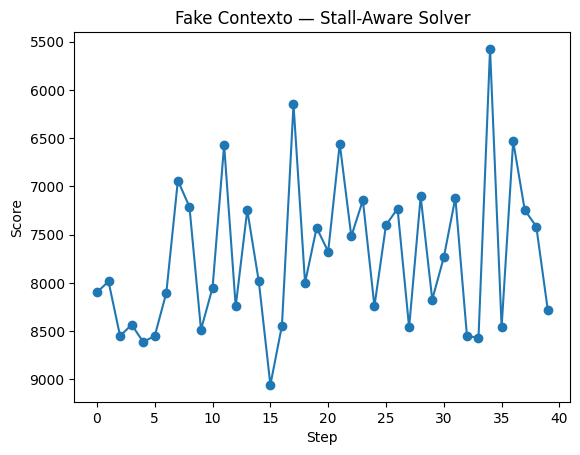

In [53]:
import matplotlib.pyplot as plt

scores = [s for _, s in history]

plt.plot(scores, marker="o")
plt.gca().invert_yaxis()  # lower is better
plt.xlabel("Step")
plt.ylabel("Score")
plt.title("Fake Contexto — Stall-Aware Solver")
plt.show()


In [ ]:
import numpy as np
import random

def run_fake_contexto_guided_jump(
    start_word,
    max_steps=50,
    top_k=5,
    stall_window=5,
    band=(0.1, 0.3)   # similarity band to best guess
):
    """
    Fake Contexto solver with:
    - directional descent
    - stall detection
    - guided exploration jumps (best-anchored)
    """

    history = []
    guessed = set()

    current = start_word
    guessed.add(current)

    best_score_seen = float("inf")

    print(f"TARGET = {TARGET}")
    print("-" * 40)

    for step in range(max_steps):
        score = fake_score(current)
        history.append((current, score))

        print(f"{step+1:02d}: {current:15s} score={score}")

        if score == 0:
            print("Solved!")
            break

        # update best
        if score < best_score_seen:
            best_score_seen = score

        # identify best word so far
        best_word, best_score = min(history, key=lambda x: x[1])
        best_vec = vector(best_word)

        # stall detection
        if len(history) >= stall_window:
            recent = [s for _, s in history[-stall_window:]]
            if min(recent) >= best_score_seen:
                # guided jump: words moderately similar to best
                candidates = []
                for w in vocab:
                    if w in guessed:
                        continue
                    sim = cosine_similarity(vector(w), best_vec)
                    if band[0] <= sim <= band[1]:
                        candidates.append(w)

                if candidates:
                    jump = random.choice(candidates)
                    print("Stall detected — guided jump to:", jump)
                    current = jump
                    guessed.add(current)
                    continue
                else:
                    # fallback: random jump
                    jump = random.choice(vocab)
                    print("Stall detected — fallback jump to:", jump)
                    current = jump
                    guessed.add(current)
                    continue

        # directional update
        best = sorted(history, key=lambda x: x[1])[:top_k]
        worst = sorted(history, key=lambda x: x[1], reverse=True)[:top_k]

        best_vec = np.mean([vector(w) for w, _ in best], axis=0)
        worst_vec = np.mean([vector(w) for w, _ in worst], axis=0)

        direction = best_vec - worst_vec - 0.5 * GLOBAL_MEAN

        candidates = []
        for w in vocab:
            if w in guessed:
                continue
            sim = cosine_similarity(direction, vector(w))
            candidates.append((sim, w))

        candidates.sort(reverse=True)
        current = candidates[0][1]
        guessed.add(current)

    return history


In [55]:
history = run_fake_contexto_guided_jump("music")


TARGET = river
----------------------------------------
01: music           score=8099
02: disambiguation  score=7985
03: png             score=8552
04: jpg             score=8434
05: colspan         score=8613
⚠️  Stall detected — guided jump to: centralize
06: centralize      score=7349
⚠️  Stall detected — guided jump to: steamer
07: steamer         score=4029
⚠️  Stall detected — guided jump to: decibels
08: decibels        score=8729
⚠️  Stall detected — guided jump to: gtpases
09: gtpases         score=7669
⚠️  Stall detected — guided jump to: metallica
10: metallica       score=8723
⚠️  Stall detected — guided jump to: geographic
11: geographic      score=5703
⚠️  Stall detected — guided jump to: tanya
12: tanya           score=8086
⚠️  Stall detected — guided jump to: londoners
13: londoners       score=8582
⚠️  Stall detected — guided jump to: zachary
14: zachary         score=7498
⚠️  Stall detected — guided jump to: maximized
15: maximized       score=7813
⚠️  Stall detected

In [ ]:
import re
import random
import numpy as np

# 1) Clean vocab for gameplay (filters out png/jpg/colspan etc.)
CLEAN_VOCAB = [
    w for w in vocab
    if re.fullmatch(r"[a-z]+", w) and 3 <= len(w) <= 20
]

print("Raw vocab:", len(vocab), "Clean vocab:", len(CLEAN_VOCAB))

def run_fake_contexto_v5(
    start_word,
    max_steps=60,
    top_k=8,
    stall_window=8,
    jump_pool=300
):
    """
    v5:
    - proper stall detection (based on last improvement step)
    - cleans vocab to avoid markup tokens
    - guided jump: choose a candidate that is:
        close to best centroid,
        far from worst centroid,
        and not too generic (global mean penalty)
    """

    history = []
    guessed = set()

    current = start_word
    if current not in word_to_idx:
        current = random.choice(CLEAN_VOCAB)
    guessed.add(current)

    best_score_seen = float("inf")
    last_improve_step = -1

    print(f"TARGET = {TARGET}")
    print("-" * 40)

    for step in range(max_steps):
        score = fake_score(current)
        history.append((current, score))
        print(f"{step+1:02d}: {current:15s} score={score}")

        if score == 0:
            print("🎯 Solved!")
            break

        # update global best + improvement time
        if score < best_score_seen:
            best_score_seen = score
            last_improve_step = step

        # compute centroids from history
        best = sorted(history, key=lambda x: x[1])[:top_k]
        worst = sorted(history, key=lambda x: x[1], reverse=True)[:top_k]

        best_vec = np.mean([vector(w) for w, _ in best], axis=0)
        worst_vec = np.mean([vector(w) for w, _ in worst], axis=0)

        # ---------- STALL DETECTION (fixed) ----------
        stalled = (step - last_improve_step) >= stall_window

        if stalled:
            # sample a pool (fast) and pick the best by an objective
            pool = []
            while len(pool) < jump_pool:
                w = random.choice(CLEAN_VOCAB)
                if w not in guessed:
                    pool.append(w)

            def objective(w):
                vw = vector(w)
                return (
                    cosine_similarity(best_vec, vw)
                    - 0.7 * cosine_similarity(worst_vec, vw)
                    - 0.3 * cosine_similarity(GLOBAL_MEAN, vw)
                )

            jump = max(pool, key=objective)
            print("Stall detected — guided jump to:", jump)
            current = jump
            guessed.add(current)
            continue

        # ---------- NORMAL STEP (directional descent) ----------
        direction = best_vec - worst_vec - 0.3 * GLOBAL_MEAN

        # choose best candidate by similarity to direction (sampled for speed)
        pool = []
        while len(pool) < 2000:
            w = random.choice(CLEAN_VOCAB)
            if w not in guessed:
                pool.append(w)

        current = max(pool, key=lambda w: cosine_similarity(direction, vector(w)))
        guessed.add(current)

    return history


Raw vocab: 71269 Clean vocab: 70625


In [ ]:
history = run_fake_contexto_v5("music")

TARGET = river
----------------------------------------
01: music           score=8099
02: subdivided      score=7688
03: width           score=7110
04: www             score=8186
05: est             score=8621
06: addison         score=8331
07: centred         score=6780
08: vol             score=8758
09: import          score=9326
10: firth           score=4845
11: shore           score=3578
12: isthmus         score=3912
13: hilly           score=3850
14: causeway        score=3818
15: tagus           score=2849
16: shetland        score=6605
17: impassable      score=4525
18: orkney          score=6239
19: northwards      score=4330
20: bastions        score=5519
21: strongholds     score=6018
22: scheldt         score=3217
23: thessaly        score=4736
⚠️  Stall detected — guided jump to: escarpment
24: escarpment      score=2852
⚠️  Stall detected — guided jump to: stretch
25: stretch         score=4852
⚠️  Stall detected — guided jump to: lava
26: lava            score=5127
⚠️ 